## Latency Comparison Xp

Goal is to measure end-to-end latency of Qdrant vector search calls (embedding + search) for different query sizes and parallel workloads. Then compare it to search through relational database. 

In [1]:
import os 
import re
import requests
import sys
import time
import statistics
import concurrent.futures
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql

import warnings
warnings.filterwarnings("ignore")

### Vector Xp 
<b>Goal:</b> <br> 
Measure the query latency of QDrant to evaluate the performance of search operations in a vector database. 

<b>Method:</b><br> 
A sample vector was used to query an existing collection multiple times, recording the response time for each search. The collected latencies were then analyzed and visualized as a histogram to understand performance distribution.

<b>Before running:</b><br>
Make sure Qdrant is running and has at least one collection, e.g. "documents".
You can verify it by running: 
```console
curl <QDRANT_URL>/collections
```

In [2]:
QDRANT_URL = "http://localhost:6333"
COLLECTION_NAME = "papers_poc"
VECTOR_DIM = 384
NUM_TESTS = 1000
TOP_K = 5

In [3]:
def generate_random_vector(dim=VECTOR_DIM):
    """Generate a random vector of given dimension."""
    return np.random.rand(dim).tolist()

latencies = []

for i in range(NUM_TESTS):
    vector = generate_random_vector()
    payload = {"vector": vector, "limit": TOP_K}

    start = time.perf_counter()
    resp = requests.post(f"{QDRANT_URL}/collections/{COLLECTION_NAME}/points/search", json=payload)
    end = time.perf_counter()

    if resp.status_code != 200:
        print(f"Search {i} failed: {resp.text}")
        continue

    points = resp.json().get("result", [])
    latencies.append(end - start)

print("QDrant Search Latency ")
print(f"Min: {min(latencies):.4f}s")
print(f"Max: {max(latencies):.4f}s")
print(f"Avg: {sum(latencies)/len(latencies):.4f}s")

QDrant Search Latency 
Min: 0.0032s
Max: 0.0181s
Avg: 0.0037s


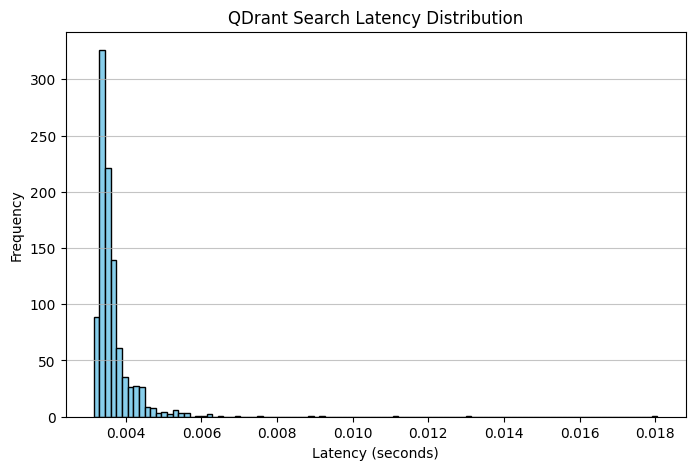

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(latencies, bins=100, color='skyblue', edgecolor='black')
plt.title("QDrant Search Latency Distribution")
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

### Search Xp 
<b> Goal: </b> <br> Measure the average latency and stability of Qdrant vector searches across multiple keywords.

<b> Method: </b> <br> Each keyword is embedded and queried multiple times against Qdrant, with per-query latencies recorded and aggregated into statistical metrics.

In [5]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from app.services.qdrant_wrapper import QdrantWrapper
from app.services.embedder import Embedder

In [6]:
KEYWORDS = [
    "HEPA filter", "PM2.5", "air purifier", "indoor air quality",
    "CO2 reduction", "VOCs", "filtration efficiency", "green wall",
    "UV light disinfection", "wearable air cleaner"
]

In [ ]:
qdrant = QdrantWrapper()
embedder = Embedder()

N_ITER = 100

records, latencies_all = [], [] 

for kw in tqdm(KEYWORDS, desc="Keywords"):
    q_emb = embedder.embed([kw])[0]

    latencies, hits_length = [], [] 
    for i in range(N_ITER):
        start = time.time()
        hits = qdrant.search(q_emb, top_k=5)
        end = time.time()

        latencies.append(end - start)
        hits_length.append(len(hits))

    latencies_all.extend(latencies)
    stats = {
        "keyword": kw,
        "n_runs": N_ITER,
        "latency_mean": np.mean(latencies),
        "latency_std": np.std(latencies),
        "latency_min": np.min(latencies),
        "latency_max": np.max(latencies),
        "avg_hits": np.mean(hits_length)
    }
    records.append(stats)


In [8]:
df_results = pd.DataFrame(records)
print("\nSummary:")
display(df_results)


Summary:


,keyword,n_runs,latency_mean,latency_std,latency_min,latency_max,avg_hits
0,HEPA filter,100,0.008245,0.006495,0.005059,0.064378,5.0
1,PM2.5,100,0.007312,0.001977,0.005107,0.020617,5.0
2,air purifier,100,0.007619,0.007368,0.004973,0.076968,5.0
3,indoor air quality,100,0.007299,0.006671,0.004891,0.070826,5.0
4,CO2 reduction,100,0.007511,0.005181,0.004705,0.044582,5.0
5,VOCs,100,0.009458,0.008935,0.004861,0.065946,5.0
6,filtration efficiency,100,0.010410,0.005417,0.006818,0.044051,5.0
7,green wall,100,0.010234,0.007244,0.006329,0.070140,5.0
8,UV light disinfection,100,0.009949,0.005424,0.006516,0.049932,5.0
9,wearable air cleaner,100,0.016012,0.020908,0.006434,0.133165,5.0


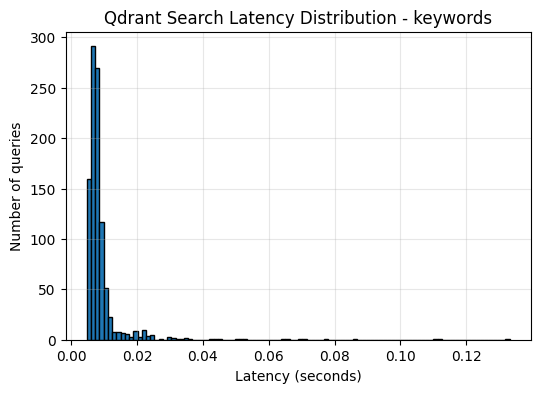

In [9]:
plt.figure(figsize=(6, 4))
plt.hist(latencies_all, bins=100, edgecolor='black')
plt.title("Qdrant Search Latency Distribution - keywords")
plt.xlabel("Latency (seconds)")
plt.ylabel("Number of queries")
plt.grid(True, alpha=0.3)
plt.show()

### Comparison to Relational DB search 
<b>Goal: </b><br>
Compare the search latency of Qdrant (vector similarity search) with a traditional relational SQL (SQLite)database performing text-based searches on paper metadata.

<b>Method:</b><br>
For a predefined list of keywords, run equivalent queries in both systems, using semantic vector search in Qdrant and regular-expression-based text search across multiple columns in the SQL database, and measure the average and distribution of response times for each approach.

<b>Before running:</b><br>
Make sure that MySQL is running and it contains papers_db with data from clean air (papers_v2.sql).
To setup it: <br>
1. Install MySQL (e.g., via Homebrew): <br>
```console
brew install mysql
```
2. Start MySQL locally: 
```console
brew services start mysql
```
3. Log in to MySQL:
```console
mysql -u root -p
```
4. Create the database:
```sql
CREATE DATABASE papers_db;
USE papers_db;
```
3. Import the SQL file:
```console
mysql -u user -p papers_db <path to papers_v2.sql>
```



In [10]:
conn = pymysql.connect(
    host='localhost',
    user='root',
    password='',
    database='papers_db'
)

N_BOOTSTRAP = 100
results_relational, latencies_all_relational = [], [] 
with conn.cursor() as cursor:
    for kw in KEYWORDS:
        latencies = []
        hits_counts = []
        
        for _ in range(N_BOOTSTRAP):
            start = time.time()
            sql_query = """
                SELECT ID, TITLE_OF_THE_PAPER, AIM_OF_THE_PAPER
                FROM papers
                WHERE TITLE_OF_THE_PAPER LIKE %s OR AIM_OF_THE_PAPER LIKE %s
                LIMIT 5
            """
            cursor.execute(sql_query, (f"%{kw}%", f"%{kw}%"))
            rows = cursor.fetchall()
            latency = time.time() - start
            
            latencies.append(latency)
            hits_counts.append(len(rows))

        latencies_all_relational.extend(latencies)

        results_relational.append({
            "keyword": kw,
            "mean_latency_sec": np.mean(latencies),
            "median_latency_sec": np.median(latencies),
            "min_latency_sec": np.min(latencies),
            "max_latency_sec": np.max(latencies),
            "hits_counts": np.mean(hits_counts)
        })
        
conn.close()

In [11]:
df_results = pd.DataFrame(results_relational)
print("\nSummary MySQL:")
display(df_results)


Summary MySQL:


,keyword,mean_latency_sec,median_latency_sec,min_latency_sec,max_latency_sec,hits_counts
0,HEPA filter,0.000924,0.000823,0.000728,0.002289,5.0
1,PM2.5,0.000261,0.000245,0.000225,0.000494,5.0
2,air purifier,0.000202,0.000188,0.000180,0.000373,5.0
3,indoor air quality,0.000221,0.000203,0.000196,0.000441,5.0
4,CO2 reduction,0.006740,0.006845,0.003971,0.008062,0.0
5,VOCs,0.001081,0.001107,0.000717,0.001544,5.0
6,filtration efficiency,0.000998,0.000966,0.000834,0.001589,5.0
7,green wall,0.006614,0.006403,0.003388,0.039287,5.0
8,UV light disinfection,0.005786,0.006200,0.003315,0.009673,0.0
9,wearable air cleaner,0.005464,0.006098,0.003093,0.007441,0.0


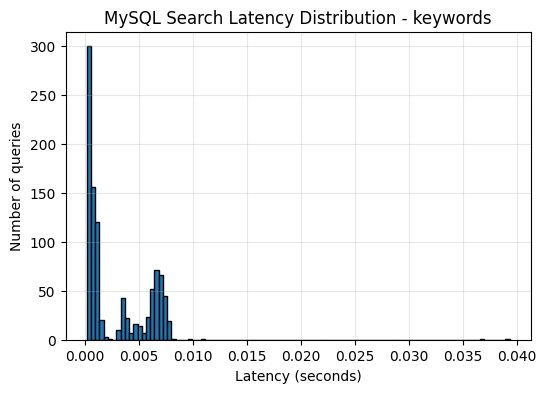

In [12]:
plt.figure(figsize=(6, 4))
plt.hist(latencies_all_relational, bins=100, edgecolor='black')
plt.title("MySQL Search Latency Distribution - keywords")
plt.xlabel("Latency (seconds)")
plt.ylabel("Number of queries")
plt.grid(True, alpha=0.3)
plt.show()

### Comparison

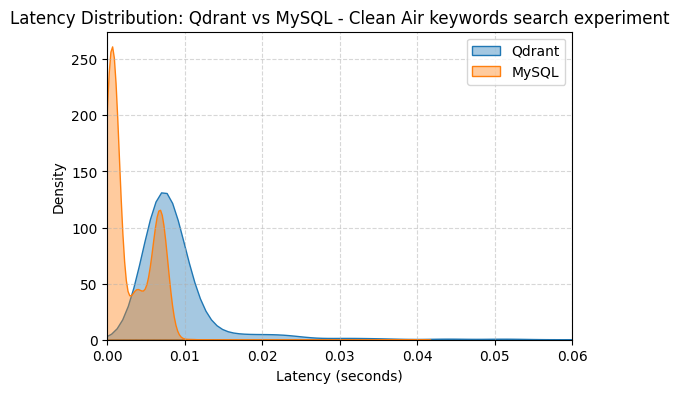

In [17]:
plt.figure(figsize=(6, 4))
sns.kdeplot(latencies_all, label="Qdrant", fill=True, alpha=0.4)
sns.kdeplot(latencies_all_relational, label="MySQL", fill=True, alpha=0.4)

plt.xlabel("Latency (seconds)")
plt.ylabel("Density")
plt.title("Latency Distribution: Qdrant vs MySQL - Clean Air keywords search experiment")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlim([0, 0.06])
plt.show()